<a href="https://colab.research.google.com/github/HankRobot/Foundations-in-Machine-Learning/blob/main/Softmax_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Softmax Regression
https://www.kdnuggets.com/2016/07/softmax-regression-related-logistic-regression.html#:~:text=Softmax%20Regression%20(synonyms%3A%20Multinomial%20Logistic,the%20classes%20are%20mutually%20exclusive).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import jax.numpy as jnp
from jax import grad
from jax import random

### Linear function for score 
For data point x, the score for class  k  is  $a_k=w_{k0}+∑_jw_{kj}x_j=w_0+w^⊤_kx$ . The predicted probability is
$y_k=exp(a_k)/∑_iexp(a_i)$.
 
Below we give different implementations of the probability. First, via a for loop, so you can see all the components appearing explicitly. Next, in softmax_prob1 this is presented in vectorised form. Note that exponentiation can cause over/under flow problems. There is a fix that I have introduced that relies on
$y_k=exp(a_k−A)/∑_iexp(a_i−A)$
 
for any  A .

In [ ]:
def softmax_prob_forloop(W, b, inputs): # output is datalen-by-C (NumPy, no JAX here)
    # inputs is dim-by-datalen
    # b is C-dimensional vector W is (C-by-dim)
    dim, datalen = np.shape(inputs) # how many dimensions, points
    c = len(b) # number of classes, C, each class has a bias 
    score = np.zeros((c, datalen))
    for ci in range(c):
        for lj in range(datalen):
            score[ci, lj] = b[ci]
            for dk in range(dim):
                score[ci, lj] += W[ci, dk]*inputs[dk, lj]
    maxes = np.zeros(datalen)
    for lj in range(datalen):
        maxes[lj] = np.max(score[:, lj])
    for ci in range(c):
        for lj in range(datalen):
            score[ci, lj] = score[ci, lj] - maxes[lj]
    # subtract off the largest score from the bias of each class 
    # This is for stability to underflow/overflow when exponentiating
    expscore = np.exp(score)
    norm_factor = np.diag(1/np.sum(expscore, axis=0))
    return np.dot(expscore, norm_factor).T  


# below we convert the same steps into vector form, hence no for loops

def softmax_prob1(W, b, inputs):  # output is datalen-by-C
    # inputs is dim-by-datalen
    # b is C-dimensional vector W is (C-by-dim)
    # Make sure all numerical operations are from JAX, so 'jnp', not 'np'
    datalen = jnp.shape(inputs)[1] # how many points
    c = len(b) # number of classes, C, each class has a bias 
    linear_part = jnp.dot(W, inputs) # (C-by-dim)*(dim-by-datalen) = C-by-datalen
    large = jnp.max(linear_part, axis=0) # largest of the class scores for each data point
    bias_offset = jnp.dot(jnp.diag(b),jnp.ones((c, datalen))) # (C-by-C)*(C-by-L)
    # subtract off the largest score from the bias of each class for stability to underflow/overflow
    large_offset = jnp.dot(np.ones((c, datalen)),jnp.diag(large)) #  (C-by-L)*(L-by-L)    
    expscore = jnp.exp(linear_part + bias_offset - large_offset)
    norm_factor = jnp.diag(1/jnp.sum(expscore, axis=0))
    return jnp.dot(expscore, norm_factor).T 

In what follows, the trick of setting the zeroth feature to be 1 is used to absorb the constant  $w_0$  into the dot product. Redefine the input data to be
$x=(x1,…,xp)⟶x=(1,x1,…,xp)$.
 
Correspondingly redefining the weight vectors to be  $w=(w0,w1,…,wp)$ , we have:
$w_{k0}+w^⊤_kx⟶w^⊤_kx$.
 
Thus the softmax_prob below has all the weights packaged into a matrix W as in the lecture slides.

In [ ]:
def softmax_prob(W, inputs):  
    # output is datalen-by-C
    # inputs is (dim)-by-datalen
    # W is C-by-(dim+1)
    # Make sure all numerical operations are from JAX, so 'jnp', not 'np'
    datalen = jnp.shape(inputs)[1] # how many points
    c = len(W) # number of classes, C, each class has a bias
    inputs = jnp.concatenate((jnp.ones((1,datalen)), inputs), axis=0)
    # create inputs (dim+1)-by-datalen 
    score = jnp.dot(W,inputs) 
    # (C-by-(1+dim))*((1+dim)-by-datalen) = C-by-datalen
    large = jnp.max(score, axis=0) # largest of the class scores for each data point
    # subtract off the largest score from the bias of each class for stability to underflow/overflow
    large_offset = jnp.dot(np.ones((c, datalen)),jnp.diag(large)) #  (C-by-L)*(L-by-L)    
    expscore = jnp.exp(score  - large_offset)
    norm_factor = jnp.diag(1/jnp.sum(expscore, axis=0))
    return jnp.dot(expscore, norm_factor).T  

In [ ]:
def softmax_xentropy(Wb, inputs, targets, num_classes):
    epsilon = 1e-8
    ys = get_one_hot(targets, num_classes)
    logprobs = -jnp.log(softmax_prob(Wb, inputs)+epsilon)
    return jnp.mean(ys*logprobs)

In [ ]:
def get_one_hot(targets, num_classes):
    res = jnp.eye(num_classes)[jnp.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[num_classes])

In [ ]:
Wb = jnp.array([[-3., 1.3, 2.0, -1.0], [-6., -2., -3., 1.5], [1., 2.0, 2.0, 2.5], [3., 4.0, 4.0, -2.5]])
# Build a toy dataset: 6 3-dim points with C=4  targets dim-by-datalen
inputs = jnp.array([[0.52, 1.12,  0.77],
                    [3.82, -6.11, 3.15],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39],
                   [0.14, -0.43, -1.69]]).T # transpose to make it a dim-by-datalen array
targets = jnp.array([0, 1, 3, 2, 1, 2])
print(inputs)
print(targets)

[[ 0.52  3.82  0.88  0.52  0.74  0.14]
 [ 1.12 -6.11 -1.08  0.06 -2.49 -0.43]
 [ 0.77  3.15  0.15 -1.3   1.39 -1.69]]
[0 1 3 2 1 2]


In [ ]:
# Initialize random model coefficients
key = random.PRNGKey(0)
key, W_key= random.split(key, 2)
[classes, dim] = 4, 3
Winit = random.normal(W_key, (classes, dim+1))
print(Winit)

[[ 0.20820075 -1.0580498  -0.2937458  -0.44117242]
 [ 0.2366985  -0.03426379 -1.002556    1.1560112 ]
 [-0.538138   -0.48968914  0.2493904  -1.4128864 ]
 [ 1.8543109   0.22756508  0.4975155  -2.0896842 ]]


## Automatic Differentiation used here
Here, we will not explicitly define what the exact form of the gradient of the cross entropy loss function is. Recall, for linear regression, we computed the gradient and used it to reduce the loss. In this next code block, we will invoke

grad(softmax_xentropy, (0))(W1, inputs, targets, num_classes)

where the (0) is shorthand for argnums=0 which indicates that we take the gradient with respect to the first (using python's indexing convention of starting from 0) of the arguments of softmax_entropy. How this is done will be explored in another lab sheet.

In [ ]:
def grad_descent(Wb, inputs, targets, num_classes,  lrate, nsteps):
    W1 = Wb
    Whist = [W1]
    losshist = [softmax_xentropy(W1,inputs, targets, num_classes )]
    eta = lrate # learning rate
    for i in range(nsteps):        
        gWb = grad(softmax_xentropy, (0))(W1, inputs, targets, num_classes)
        W1 = W1 - eta*gWb
        if (i%5 ==0):
            Whist.append(W1)
            losshist.append(softmax_xentropy(W1, inputs, targets, num_classes))
    Whist.append(W1)
    losshist.append(softmax_xentropy(W1, inputs, targets, num_classes))    
    return W1, Whist, losshist

In [ ]:
W2, Whist, losshist = grad_descent(Winit, inputs, targets, 4, 0.75, 200)

### Loss history
Now that we have the initial weights Winit, the history of weights and the history of losses, we can see how the loss function reduces as a function of iteration step. You should experiment with different learning rates and iteration steps, etc.

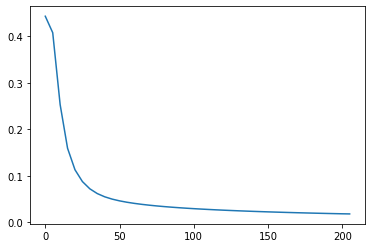

In [ ]:
plt.plot([5*i for i in range(len(losshist))], losshist)

Compare the predictions with the targets. First, we see what the randomly initialised weights produced as the predicted probabilities. Then we note the final (at the point that we stopped the iterations) prediction and compare that with the target.

In [ ]:
print('From:\n',np.around(softmax_prob(Winit, inputs),3))
print('To:\n',np.around(softmax_prob(W2, inputs),3))
print('Target:\n',get_one_hot(targets, 4))


From:
 [[0.09  0.243 0.05  0.618]
 [0.    1.    0.    0.   ]
 [0.073 0.507 0.028 0.392]
 [0.011 0.002 0.025 0.962]
 [0.008 0.99  0.    0.002]
 [0.013 0.001 0.028 0.957]]
To:
 [[0.951 0.009 0.006 0.034]
 [0.    0.996 0.    0.004]
 [0.025 0.13  0.043 0.802]
 [0.004 0.    0.949 0.047]
 [0.001 0.926 0.    0.074]
 [0.    0.    0.979 0.021]]
Target:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


# Your turn:
Create your own input data and targets. You may choose them to be random. For instance, in numpy np.random.normal(mean, std_dev,(dim, datalen)) will create a set of datalen inputs of dimension dim, drawn from a normal distribution of a chosen mean and standard deviation. You must generate the Winit from jax.numpy in order to be able to use the gradient. Experiment with different learning rates, and see what you find.

In [ ]:
# Initialize random model coefficients
key = random.PRNGKey(0)
key, W_key= random.split(key, 2)
[classes, dim] = 4, 3
Winit = random.normal(W_key, (classes, dim+1))
print(Winit)

[[ 0.20820075 -1.0580498  -0.2937458  -0.44117242]
 [ 0.2366985  -0.03426379 -1.002556    1.1560112 ]
 [-0.538138   -0.48968914  0.2493904  -1.4128864 ]
 [ 1.8543109   0.22756508  0.4975155  -2.0896842 ]]


In [ ]:
inputs = np.random.normal(1, 0.2, (6,3)).T 
targets = np.random.randint(4,size=6)
print(inputs)
print(targets)

[[1.03884827 1.22674478 1.15922851 1.04414937 0.75891913 0.85492658]
 [1.1037261  0.91104062 0.99841792 1.282987   0.54458355 0.82857137]
 [0.95715109 0.91626401 1.62206523 1.18242355 1.07221157 1.27152793]]
[3 2 0 3 0 3]


In [92]:
W2, Whist, losshist = grad_descent(Winit, inputs, targets, 4, 0.1, 200)

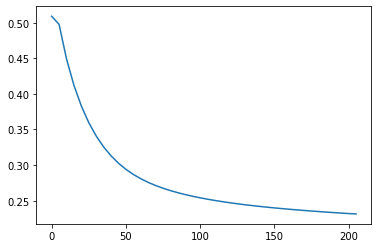

In [93]:
plt.plot([5*i for i in range(len(losshist))], losshist)

In [94]:
print('From:\n',np.around(softmax_prob(Winit, inputs),3))
print('To:\n',np.around(softmax_prob(W2, inputs),3))
print('Target:\n',get_one_hot(targets, 4))


From:
 [[0.057 0.356 0.035 0.552]
 [0.047 0.386 0.03  0.537]
 [0.037 0.821 0.012 0.13 ]
 [0.058 0.46  0.032 0.45 ]
 [0.075 0.63  0.026 0.27 ]
 [0.065 0.675 0.023 0.238]]
To:
 [[0.206 0.019 0.146 0.629]
 [0.194 0.024 0.146 0.635]
 [0.476 0.057 0.137 0.33 ]
 [0.258 0.019 0.154 0.568]
 [0.385 0.079 0.12  0.417]
 [0.408 0.058 0.13  0.404]]
Target:
 [[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]
